<a href="https://colab.research.google.com/github/mpedraza98/DSPS_MPedraza/blob/main/HW7/Gaussian_Process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


This is an exercise on feature extractoin and Gaussian Processes interpolation of sparse time series.

## OVERVIEW

The PLAsTiCC challend is a Kaggle challange to classify astrophysical objects (e.g. stars, exploding stars, stars with planets transiting, black holes) based on their time variability in light emission in 6 different bands (i.e. wavelength ranges). The sampling (the cadence of the observations) is designed to show what the upcming Rubin Observatory LSST (Legacy Survey of Space and Time) will see when it starts observing (in 2023). 

You can refer to this notebook https://www.kaggle.com/michaelapers/the-plasticc-astronomy-starter-kit (written by my good friend Gautham Narayan) to get started and ingest and preprocess the PLASTiCC challenge data. If you are not familiar with classes (object oriented syntax) do not worry about it: I do want you to extract the features yourself. So use it as a guideline, but do not just copy and paste.

Your task is to extract features, i.e. representations of the time series, and fit the time series with Gaussian Processes. 



In [1]:
!pip install matplotlib --upgrade

In [2]:
!pip install george

In [3]:
import pandas as pd
import numpy as np
import pylab as pl
from scipy import stats
from scipy.optimize import minimize
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import george
from george import kernels
%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [4]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount = True)

Mounted at /content/gdrive


In [5]:
#cd /content/gdrive/MyDrive/.kaggle

In [6]:
!pwd

/content


In [7]:
#set an variable in your system that saves your data from kaggle.json
import json
import os
#envs = json.load(open("kaggle.json", "r"))
#os.environ["KAGGLE_USERNAME"] = envs['username']
#os.environ["KAGGLE_KEY"] = envs['key']

In [8]:
cd /content/gdrive/MyDrive/MLTSA22/

/content/gdrive/MyDrive/MLTSA22


In [9]:
#!kaggle competitions download PLAsTiCC-2018 -f training_set.csv 
#!kaggle competitions download PLAsTiCC-2018 -f training_set_metadata.csv

In [10]:
#!unzip training_set.csv.zip

# TASK I :  Data Acquisition
 You can download the data from kaggle
 --- https://www.kaggle.com/c/PLAsTiCC-2018
 or from zenodo
 --- https://zenodo.org/record/2539456#.XonrIdNKjOQ
 Choose how to do it but make sure that it is a reproducible way. You will need the **training data and the metadata files** only - you wont need to use the test data


In [11]:
#!ls -l

In [12]:
lcvs = pd.read_csv('training_set.csv')

In [13]:
lcvs.head()

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [14]:
print("The shape of light curves dataset is:", lcvs.shape)

The shape of light curves dataset is: (1421705, 6)


In [15]:
#check missing values
lcvs.isna().sum()

object_id    0
mjd          0
passband     0
flux         0
flux_err     0
detected     0
dtype: int64

Read the Kaggle challenge for a description of the data . This "Starter Kit" which includes a notebook (written by y good friend Gautham Narayan) may be especially useful
https://www.kaggle.com/michaelapers/the-plasticc-astronomy-starter-kit

For each object there are 6 time series in 6 different passbands 

In [16]:
bands = lcvs["passband"].unique()
print("Passbands (filter) identifiers:", bands)

Passbands (filter) identifiers: [2 1 3 4 5 0]


In [17]:
objects = lcvs["object_id"].unique()
print("There are {} astrophysical simulated objects in my dataset".format(objects.shape[0]))

There are 7848 astrophysical simulated objects in my dataset


In [18]:
metadata = pd.read_csv("training_set_metadata.csv")
metadata.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


In [19]:
print("The metadata columns are: ", metadata.columns)

The metadata columns are:  Index(['object_id', 'ra', 'decl', 'gal_l', 'gal_b', 'ddf', 'hostgal_specz',
       'hostgal_photoz', 'hostgal_photoz_err', 'distmod', 'mwebv', 'target'],
      dtype='object')


In [20]:
print("The metadata dataset contains features: ", metadata.shape[1])

The metadata dataset contains features:  12


# TASK II : data exploration and visualization - plot some time series 
Visualize my data to get a sense of what we are working with. 





Plot light curves for 10 objects. 

In [21]:
# Dictionary that contains the name of each band according to the data_note in kaggle
bands_names = {0:'u', 1:'g', 2:'r', 3:'i', 4:'z', 5:'y'}

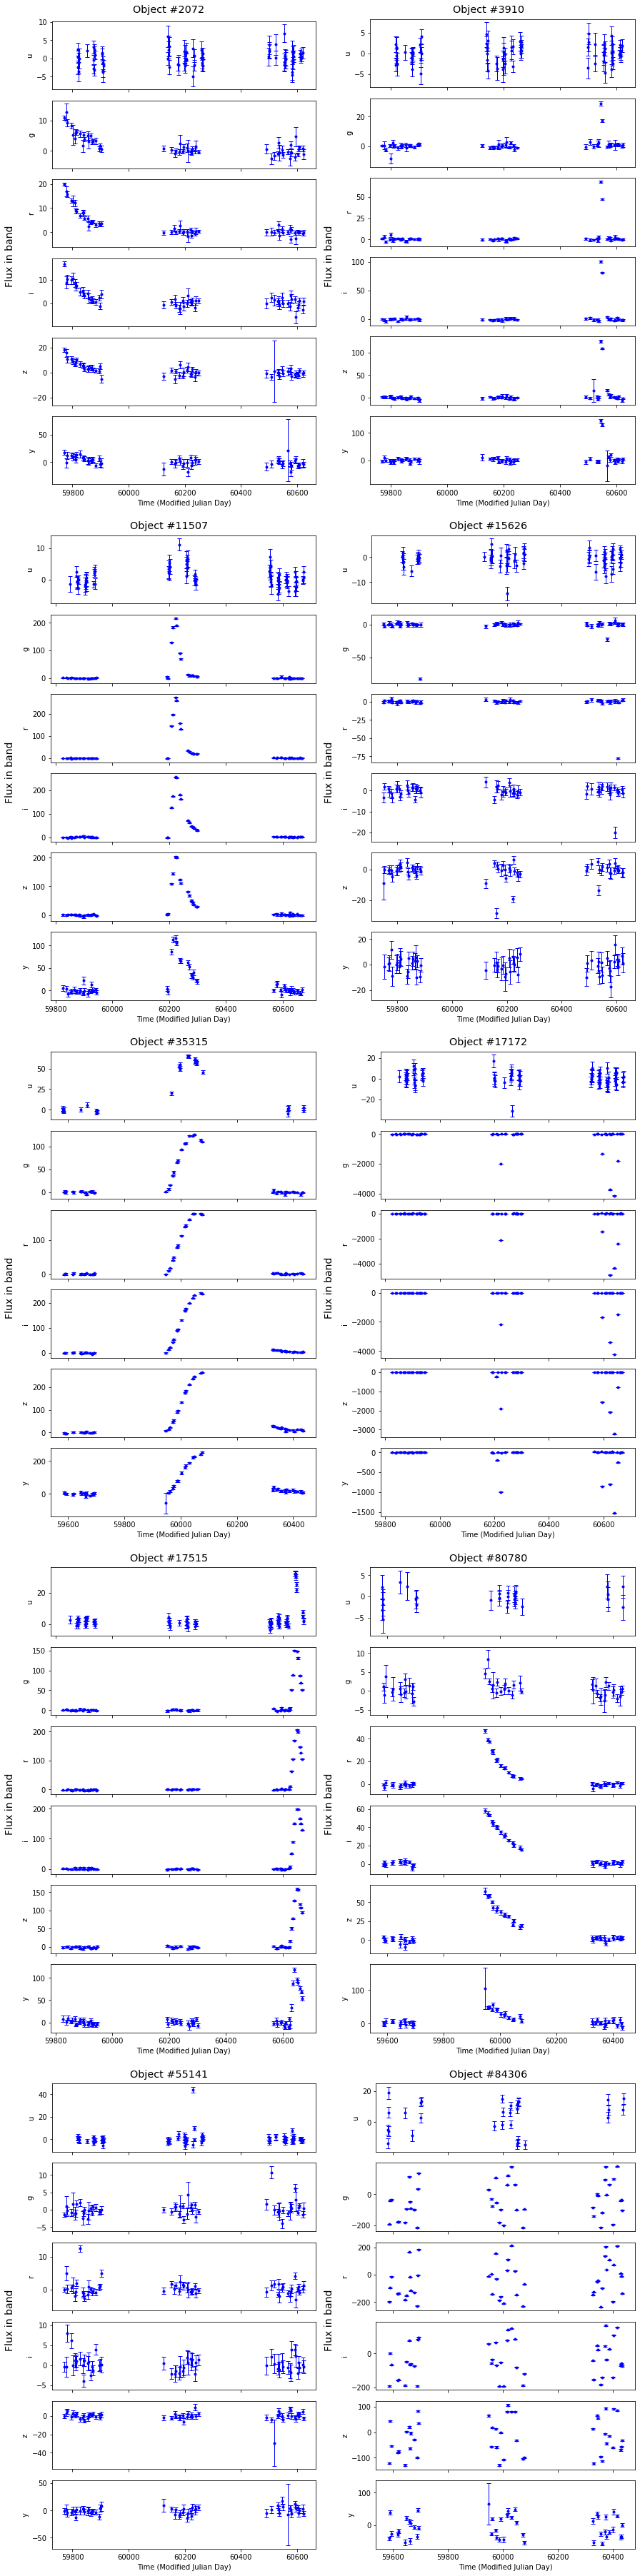

In [59]:
bandas = np.sort(lcvs[lcvs.object_id <= 84716].passband.unique())
unique_objects = lcvs[lcvs.object_id <= 84716].object_id.unique()
# Objects to be selected from the subset to visualize the data
test_index = np.array([10,21,64,89,203,102,106,478,312,499])
fig = pl.figure(constrained_layout=True, figsize=(12,50))
subfigs = fig.subfigures(5, 2, wspace=0.07)
row = 0
for h, k in enumerate(test_index):
  test_object = lcvs[lcvs.object_id == unique_objects[k]]
  axs = subfigs[row, h%2].subplots(nrows = bandas.size, ncols = 1, sharex = True)
  for ind, ax in enumerate(axs):
    temp = test_object[test_object.passband == bandas[ind]]
    ax.errorbar(temp.mjd , temp.flux, temp.flux_err, fmt='.', color='b', elinewidth=1, capsize=3)
    ax.set_ylabel(bands_names[ind])
  
  subfigs[row, h%2].suptitle('Object #{}'.format(unique_objects[k]), fontsize='x-large')
  subfigs[row, h%2].text(-0.05, 0.5, 'Flux in band', va='center', rotation='vertical', fontsize = 14)
  pl.xlabel('Time (Modified Julian Day)')

  if h%2 ==1 : row = row+1
pl.show()

**Figure 1**. Light curves for 10 random objects from the dataset. In concordance with the plots in data_notes. We found similar behavior to the one described in there, object #35315 reaches some maximum in brightness and then starts fading away. Object #80780 shows a maximum which ocurred near an observation gap, thus it does not appear completely in our data. Object #15626, shows an object that periodically brights and fades

Now, we plot object 84716 explicitly.

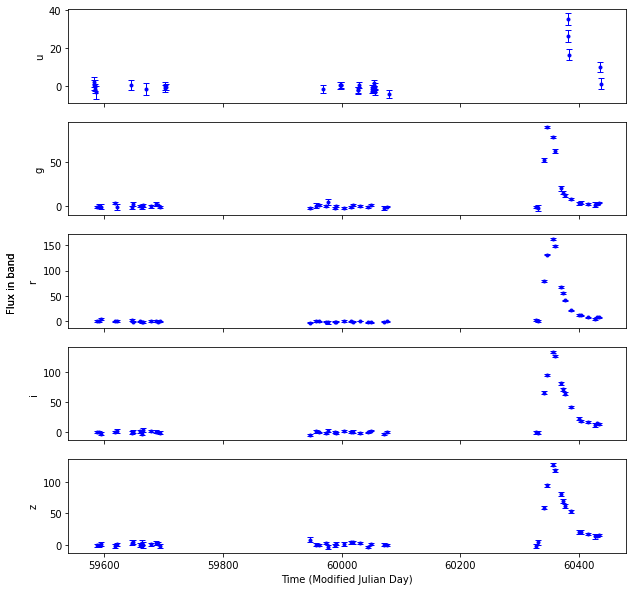

In [23]:
fig, ax = pl.subplots( 5, 1, sharex=True, figsize = (10,10))
for i, ax in enumerate(ax):
  temp = lcvs[(lcvs.object_id==84716) & (lcvs.passband == bandas[i])]
  ax.errorbar(temp.mjd , temp.flux, temp.flux_err, fmt='.', color='b', elinewidth=1, capsize=3)
  ax.set_ylabel(bands_names[i])

fig.text(0.04, 0.5, 'Flux in band', va='center', rotation='vertical')
fig.text(0.04, 0.5, 'Flux in band', va='center', rotation='vertical')
pl.xlabel('Time (Modified Julian Day)')
pl.show()

**Fig 2.** Plot explicitly object 84716. This object clearly has an event when the flux was maximum. However in band u is not as clearly appreciable as in the other bands




# TASK III: Extract features

Feature extraction refers to the extraction of statistical features of the datapoints or the generation of low dimensional representations of the data points that can then be passed to a classifier/regression

Extract at least 4 features including at least 1 feature from all three category below

The code that won the callenge did a number of smart things, of course. It was a feature based classification scheme, which included Gaussian Processes in the preprocessing. The feature extraction part of the code is here. https://github.com/kboone/avocado/blob/master/avocado/plasticc.py

Examples of features you can extract:

- **from the original lightcurve**: 
    - mean, 
    - standard deviation, 
    - skewness, 
    - kurthosis, 
    - minimum 
    - maximmum,
    - error on the minimum and 
    - error on the maximum, 
- **from the standardized lightcurve**:
    - median 
    - slope of a line fit
    - intercept of a line fit
    - likelihood of the line fit
    - likelihood of a quadratic fit
    - sign of the quadratic parameter


- **from the metadata file**:
    - decl; this is one of the positions in the sky variables: important because the position on the sky may determin if it is a galactic or extragalactic object
    - ddf_bool ; the kind of survey i.e. the data collection scheme that lead to the time series
    - hostgal_photoz
    - hostgal_photoz_err
    
The feature in the metadata files are the hardest ones to decide on because they require domain knowledge.
Most of the other features in the metadata are unknown for test objects (only known for the training set)


Extract at least 4 features including 1 features from all three category above: original lcv, standardized lcv, metadata. Justify each feature. Coming up with different features than the ones I suggested is very welcome! Remember that if the features are extracted from the time series there will be 4 features for each passbands.

Note: we are working with bigg-ish data! 
First off: every new piece should be developed on a subset of the dataset, then run on all the data only when ready. 
Still, if you try achieve goals by implementing for loops you are not going to be able to run the notebook for the whole data, or even only 1 batch of the full datase. A good solution is to use the groupby() method in pandas. I used groupby everywhere. Also it may be wise to write out intermediate outputs, so you do not have to loose work if your kernel dies or something similar. 


describe each feature you plan to extract. Briefly indicate why you think it is a valuable feature and what data type is it (e.g. continuous, binary, categorical, if continuous does it have a max or min value or is it unbound?)

        

### extract some features from the raw lightcurve - 


higher order moments of the distribution can be obtained with the scipy.stats.moment() function which can be applied to a grouby() object
note that this way you can apply a function that takes only one argument, the argument over which groupby iterates (the flux here). But moments take 2: the value and the moment Create a function call

In [24]:
def momentos(x, m):
  '''
  Returns the m-th moment of the data
  Receives an array and the moment desired as arguments
  '''
  return stats.moment(x, moment = m)

In [25]:
means = lcvs.groupby(["object_id", "passband"])[["flux"]].mean()
stds = lcvs.groupby(["object_id", "passband"])[["flux"]].std()
m2 = lcvs.groupby(["object_id", "passband"])["flux"].apply(momentos, m=2)
m3 = lcvs.groupby(["object_id", "passband"])["flux"].apply(momentos, m=3)
max_lcvs = lcvs.groupby(["object_id", "passband"])[["flux"]].max()
min_lcvs = max = lcvs.groupby(["object_id", "passband"])[["flux"]].min()

In [26]:
features = means.rename({"flux": "mean"}, 
                        axis=1).merge(stds.rename({"flux": "std"}, 
                                axis=1), left_index=True, right_index=True)

In [27]:
features = features.merge(m2.rename("m2"), left_index=True, right_index=True).merge(m3.rename("m3"), 
                                                                                    left_index=True, right_index=True)

In [28]:
features = features.merge(max_lcvs.rename({"flux": "max"}, 
                                axis=1), left_index=True, right_index=True).merge(min_lcvs.rename({"flux": "min"}, 
                                axis=1), left_index=True, right_index=True)

In [29]:
features.head()

mean         std             m2            m3  \
object_id passband                                                        
615       0          -3.254554   83.944735    6934.865833  7.266579e+04   
          1        -385.699911  601.787302  355904.026224  8.593916e+07   
          2        -134.146566  455.121346  203564.138816  3.040627e+07   
          3        -121.103501  335.425053  110570.138947  1.049664e+07   
          4         -55.954592  291.803449   83681.162283  4.717542e+06   

                           max          min  
object_id passband                           
615       0         125.182808  -116.913223  
          1         660.626343 -1100.440063  
          2         611.984558  -681.858887  
          3         445.737061  -530.644592  
          4         381.953735  -422.184509

Even with the same standard deviation two distribution can be very different. 
Look at the this article for a great demonstation of that! https://heap.io/blog/data-stories/anscombes-quartet-and-why-summary-statistics-dont-tell-the-whole-story

I extracted  the max and min, but also their uncertainties because outlier points may be measurement issues, in which case the uncertainty may be large : see the plot you made for 84716!

If a distribution has spikes the standard deviation will be larger even if the other datapoints are exactly the same. Save the mean and the max of both original distribution and the standardized one (standardized = mean subtracted and divided by the standard deviation). 


Standardize the lcvs and extract some features from the raw lightcurve - 


You can do it use  the preprocessing.scale function and groupby, which group by object and band. It does its job, but it is slow

In [30]:
lcvs["fluxnormed"] = 0.
lcvs["fluxnormed_err"] = 0.

In [31]:
means_err = lcvs.groupby(["object_id", "passband"])[["flux_err"]].mean()
stds_err = lcvs.groupby(["object_id", "passband"])[["flux_err"]].std()

In [32]:
# I used parts of the code from the Final DSPS Exam
def normed(df):
  obj, band = df.object_id.values[0], df.passband.values[0]
  df["fluxnormed"] = (df["flux"] - means.loc[obj, band].values[0]) / stds.loc[obj, band].values[0]
  df["fluxnormed_err"] = (df["flux_err"] - means_err.loc[obj, band].values[0]) / stds_err.loc[obj, band].values[0]
  return df

In [33]:
lcvs = lcvs.groupby(["object_id", "passband"]).apply(normed)

In [34]:
lcvs.describe()

,object_id,mjd,passband,flux,flux_err,detected,fluxnormed,fluxnormed_err
count,1.421705e+06,1.421705e+06,1.421705e+06,1.421705e+06,1.421705e+06,1.421705e+06,1.421705e+06,1.421705e+06
mean,3.392608e+07,6.017921e+04,2.783108e+00,2.468855e+01,2.548932e+01,1.666168e-01,2.180690e-19,1.485368e-18
std,4.258439e+07,3.092379e+02,1.703946e+00,3.684506e+03,3.814492e+03,3.726336e-01,9.833005e-01,9.833005e-01
min,6.150000e+02,5.958003e+04,0.000000e+00,-1.149388e+06,4.637530e-01,0.000000e+00,-8.048259e+00,-4.280787e+00
25%,1.843400e+05,5.989905e+04,1.000000e+00,-2.789418e+00,2.118670e+00,0.000000e+00,-4.921153e-01,-6.843207e-01
50%,4.548783e+06,6.019331e+04,3.000000e+00,7.331990e-01,4.708105e+00,0.000000e+00,-2.211384e-01,-1.806802e-01
75%,6.796280e+07,6.048722e+04,4.000000e+00,8.830932e+00,1.297371e+01,0.000000e+00,3.361265e-01,5.331905e-01
max,1.307798e+08,6.067436e+04,5.000000e+00,2.432809e+06,2.234069e+06,1.000000e+00,8.354945e+00,8.079631e+00


We will also save the medians and the host_gal_photoz variable

In [35]:
medians = lcvs.groupby(["object_id","passband"])["fluxnormed"].median()

In [36]:
features = features.merge(medians, left_index=True, right_index=True)
features.rename({"fluxnormed": "median"}, axis=1, inplace=True)

In [37]:
features = features.reset_index()
features["passband"] = features["passband"].astype(str)
features = features.set_index(['object_id','passband']).stack().unstack([1,2])

In [38]:
features.columns = ['_'.join(a) for a in features.columns]

In [39]:
features.head()

,0_mean,0_std,0_m2,0_m3,0_max,0_min,0_median,1_mean,1_std,1_m2,...,4_max,4_min,4_median,5_mean,5_std,5_m2,5_m3,5_max,5_min,5_median
object_id,,,,,,,,,,,,,,,,,,,,,
615,-3.254554,83.944735,6934.865833,72665.792850,125.182808,-116.913223,-0.080537,-385.699911,601.787302,355904.026224,...,381.953735,-422.184509,-0.163078,-47.449847,294.779522,85370.493377,3.041829e+06,378.188141,-422.815094,-0.129163
713,-2.720398,7.113509,49.879128,89.634243,14.509829,-14.735178,-0.052914,-1.019804,5.712334,32.048070,...,9.827934,-12.286801,0.016870,-1.794175,7.094073,49.427194,7.377121e+01,14.770886,-14.211164,-0.094281
730,-0.048080,1.828872,3.298318,2.093148,5.942166,-3.459960,0.039463,0.141057,1.807229,3.203266,...,41.159981,-5.836310,-0.308522,4.539396,13.332758,174.276892,3.751336e+03,47.310059,-19.159811,-0.149763
745,1.797523,4.374445,18.869993,162.368381,18.014029,-3.874349,-0.169349,5.717394,25.964659,662.124902,...,183.633118,-15.494463,-0.358773,10.746138,26.060130,666.782529,5.309464e+04,141.513290,-10.249387,-0.306851
1124,0.660948,2.360084,5.481586,-4.160853,5.330927,-6.804703,-0.033864,4.634637,8.107525,64.598653,...,143.600189,-16.543753,-0.303771,6.896742,21.434627,451.382820,3.414365e+04,109.157585,-10.860540,-0.229697


In [40]:
allfeatures = features.merge(metadata[['object_id','decl']], left_index = True, right_on= 'object_id')
allfeatures.set_index('object_id', inplace= True)

In [41]:
allfeatures.head()

,0_mean,0_std,0_m2,0_m3,0_max,0_min,0_median,1_mean,1_std,1_m2,...,4_min,4_median,5_mean,5_std,5_m2,5_m3,5_max,5_min,5_median,decl
object_id,,,,,,,,,,,,,,,,,,,,,
615,-3.254554,83.944735,6934.865833,72665.792850,125.182808,-116.913223,-0.080537,-385.699911,601.787302,355904.026224,...,-422.184509,-0.163078,-47.449847,294.779522,85370.493377,3.041829e+06,378.188141,-422.815094,-0.129163,-61.943836
713,-2.720398,7.113509,49.879128,89.634243,14.509829,-14.735178,-0.052914,-1.019804,5.712334,32.048070,...,-12.286801,0.016870,-1.794175,7.094073,49.427194,7.377121e+01,14.770886,-14.211164,-0.094281,-27.784405
730,-0.048080,1.828872,3.298318,2.093148,5.942166,-3.459960,0.039463,0.141057,1.807229,3.203266,...,-5.836310,-0.308522,4.539396,13.332758,174.276892,3.751336e+03,47.310059,-19.159811,-0.149763,-6.579593
745,1.797523,4.374445,18.869993,162.368381,18.014029,-3.874349,-0.169349,5.717394,25.964659,662.124902,...,-15.494463,-0.358773,10.746138,26.060130,666.782529,5.309464e+04,141.513290,-10.249387,-0.306851,-45.586655
1124,0.660948,2.360084,5.481586,-4.160853,5.330927,-6.804703,-0.033864,4.634637,8.107525,64.598653,...,-16.543753,-0.303771,6.896742,21.434627,451.382820,3.414365e+04,109.157585,-10.860540,-0.229697,-63.823658


Note: the median of the standardizeed distribution would convey the location of the "center of mass" of the data with respect to the mean


parametric features: extract some features that come from simple models of the lightcurve, e.g. line fits



the goodness of fit for these models is also a potential feature

Data Organization: you can put all your features in a dataframe using merge at each step merging each new feature with the olde ones


NOTE: when you merge the metadata features you are going to have to do some gymnastic with the indices: this is because the data has 2 indices columns: the object id and the bandpass id, while the metadata has only 1 index: the object id. 

You can use the function unstuck - here is an example line of code of what worked for me **but** it kind of depends on how you organized your dataframe so this is not guaranteed to work!

what is the shape of your final feature space?

In [42]:
print("My feature space is {} features (columns)".format(allfeatures.shape[1]))

My feature space is 43 features (columns)


Now make histograms for allfeatures to show their distributions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


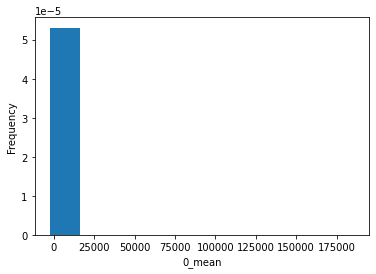

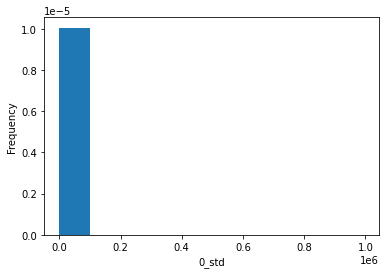

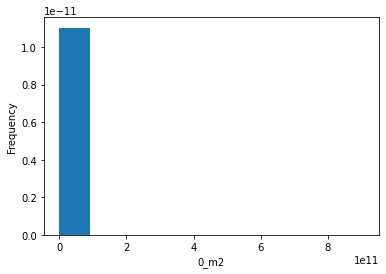

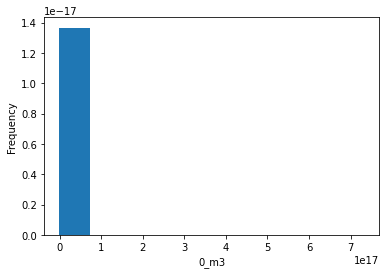

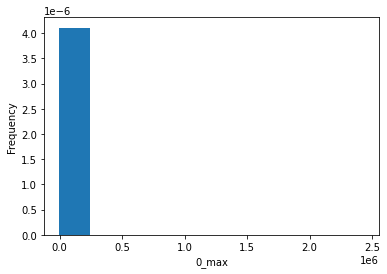

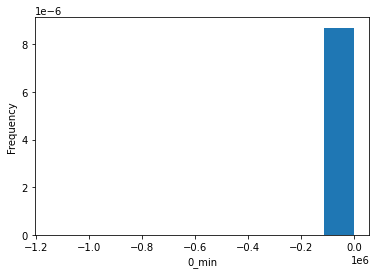

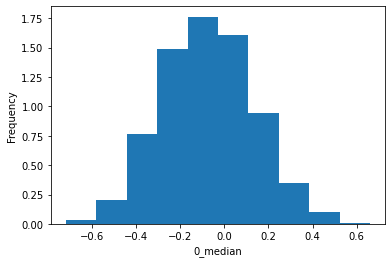

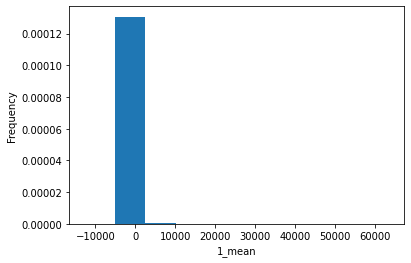

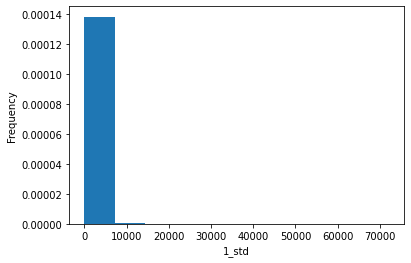

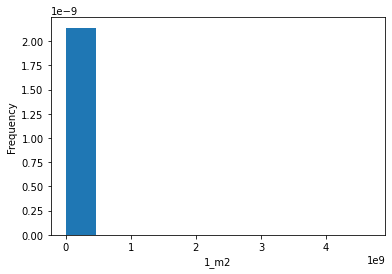

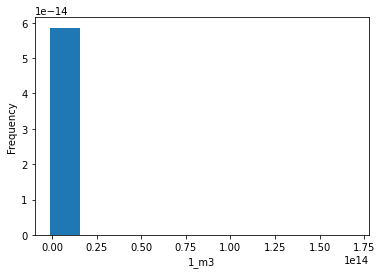

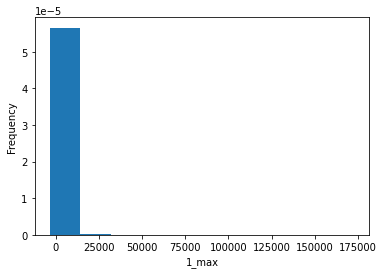

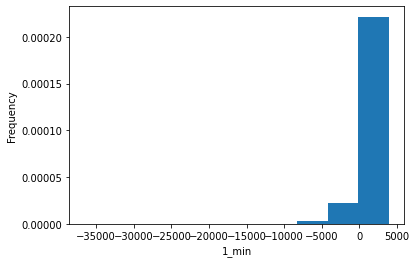

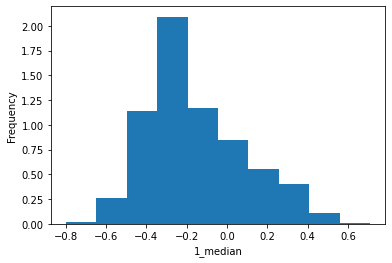

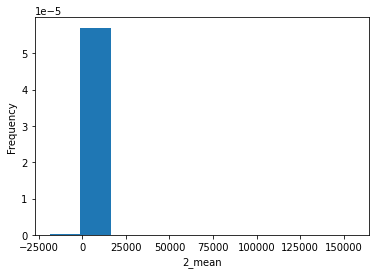

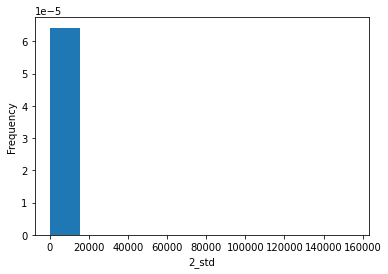

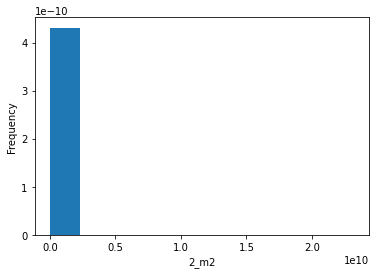

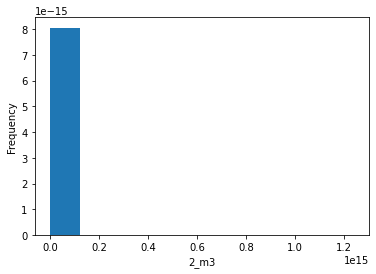

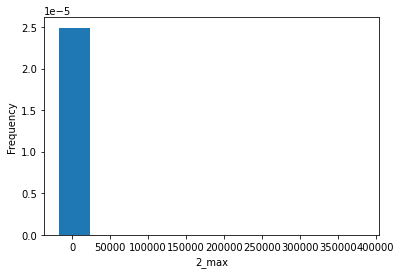

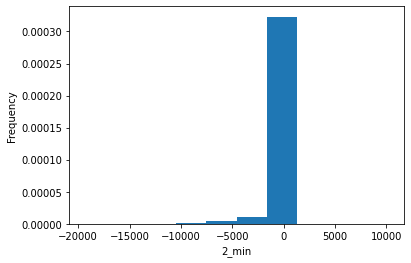

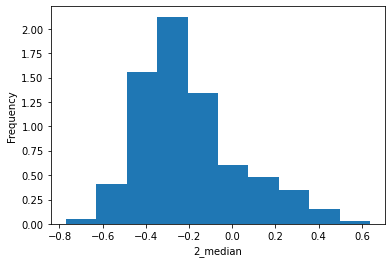

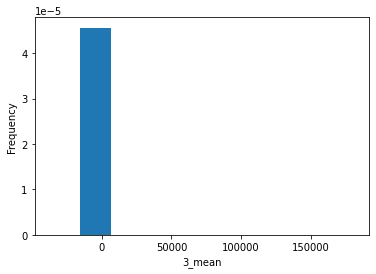

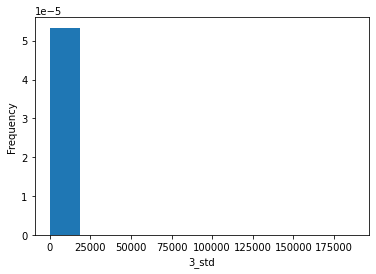

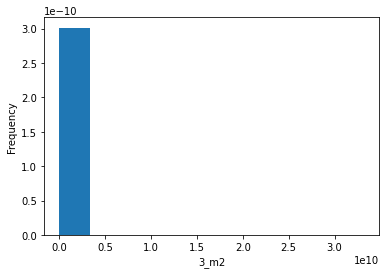

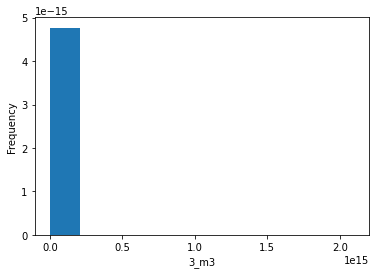

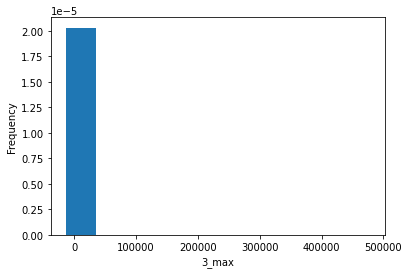

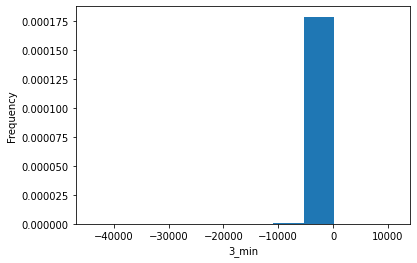

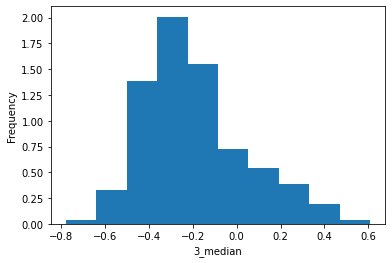

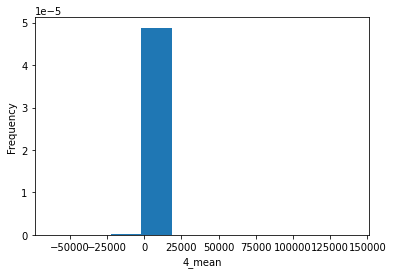

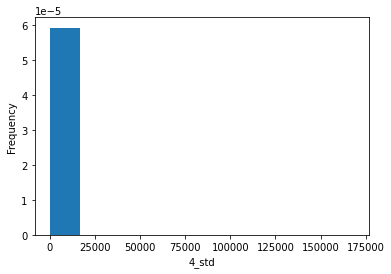

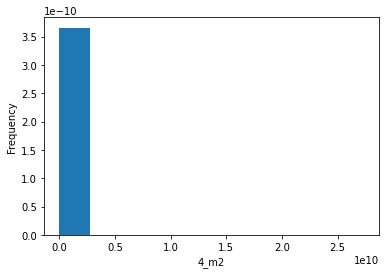

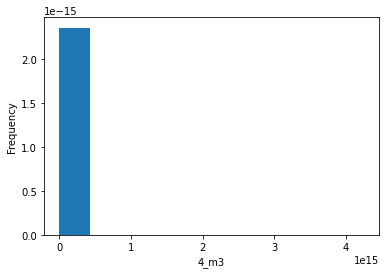

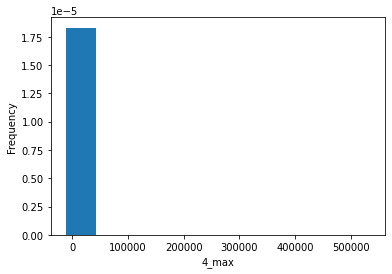

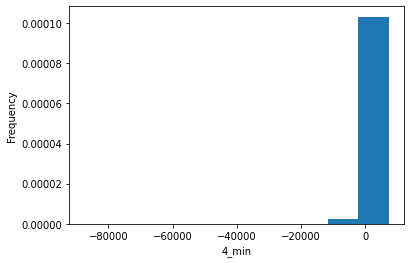

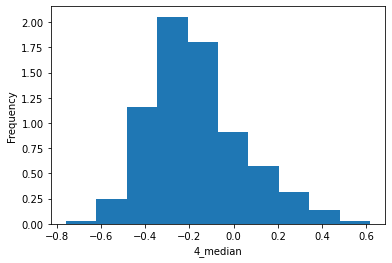

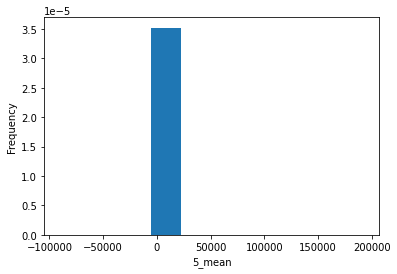

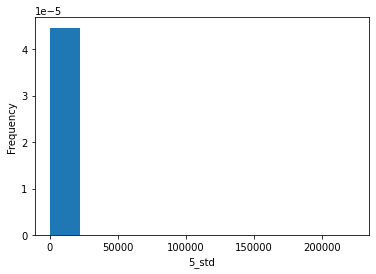

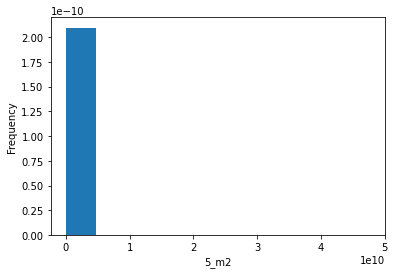

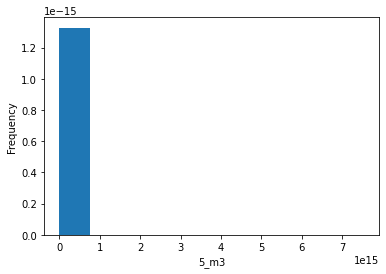

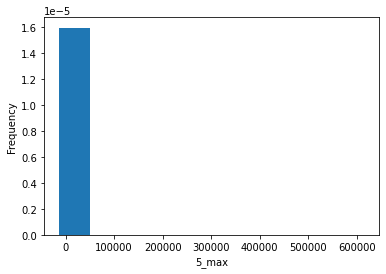

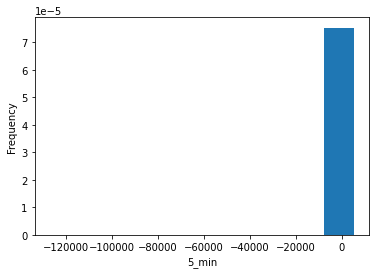

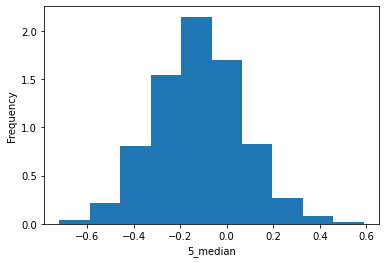

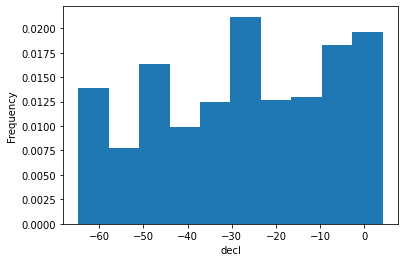

In [43]:
for i in allfeatures.columns:
  pl.figure()
  pl.hist(allfeatures[i], density = True)
  pl.xlabel(i)
  pl.ylabel('Frequency')

**Fig 3** Histogram for the features extracted from the original dataset and its normalized version. We can notice that most of the bands have mean close to zero. This is expected, as the events are spontaneous bright points that occur once in a while, whereas the general behaviour of the objects remain constant. In constrast, the means tend to be negative, this is in agreement with the behavior of the skewness which is positive.

# TASK III : Gaussian Processes

Take the time series and fit them with GPs. 
- use the george package goerge (see class demo https://github.com/fedhere/MLTSA22_FBianco/blob/main/Lab5GP/GP_examples.ipynb)
- make sure you use the standardized time series
- make sure you process the uncertainty as well as the data in the standardization!
- choose an appropriate kernel (e.g. the composite one we use in class that enables periodicity as well as stockastic variations)
- take a subset of the time series, ~10, making sure that they are of different types
- fit the GP kernerl to each time series band by band
- collect the best fit parameters and describe their variance - can all the time series be fit reasonably with the same kernel? how would you initialize the fit for the whole ensamble?



In [45]:
def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)

According to the dataset description there is a class of object which shines periodically. Therefore, I choose a combination of kernels, including the cosine kernel, that allow for the periodic behavior to be reproduced. The initial parameters are guessed and then optimized through scipy's minimize function. 

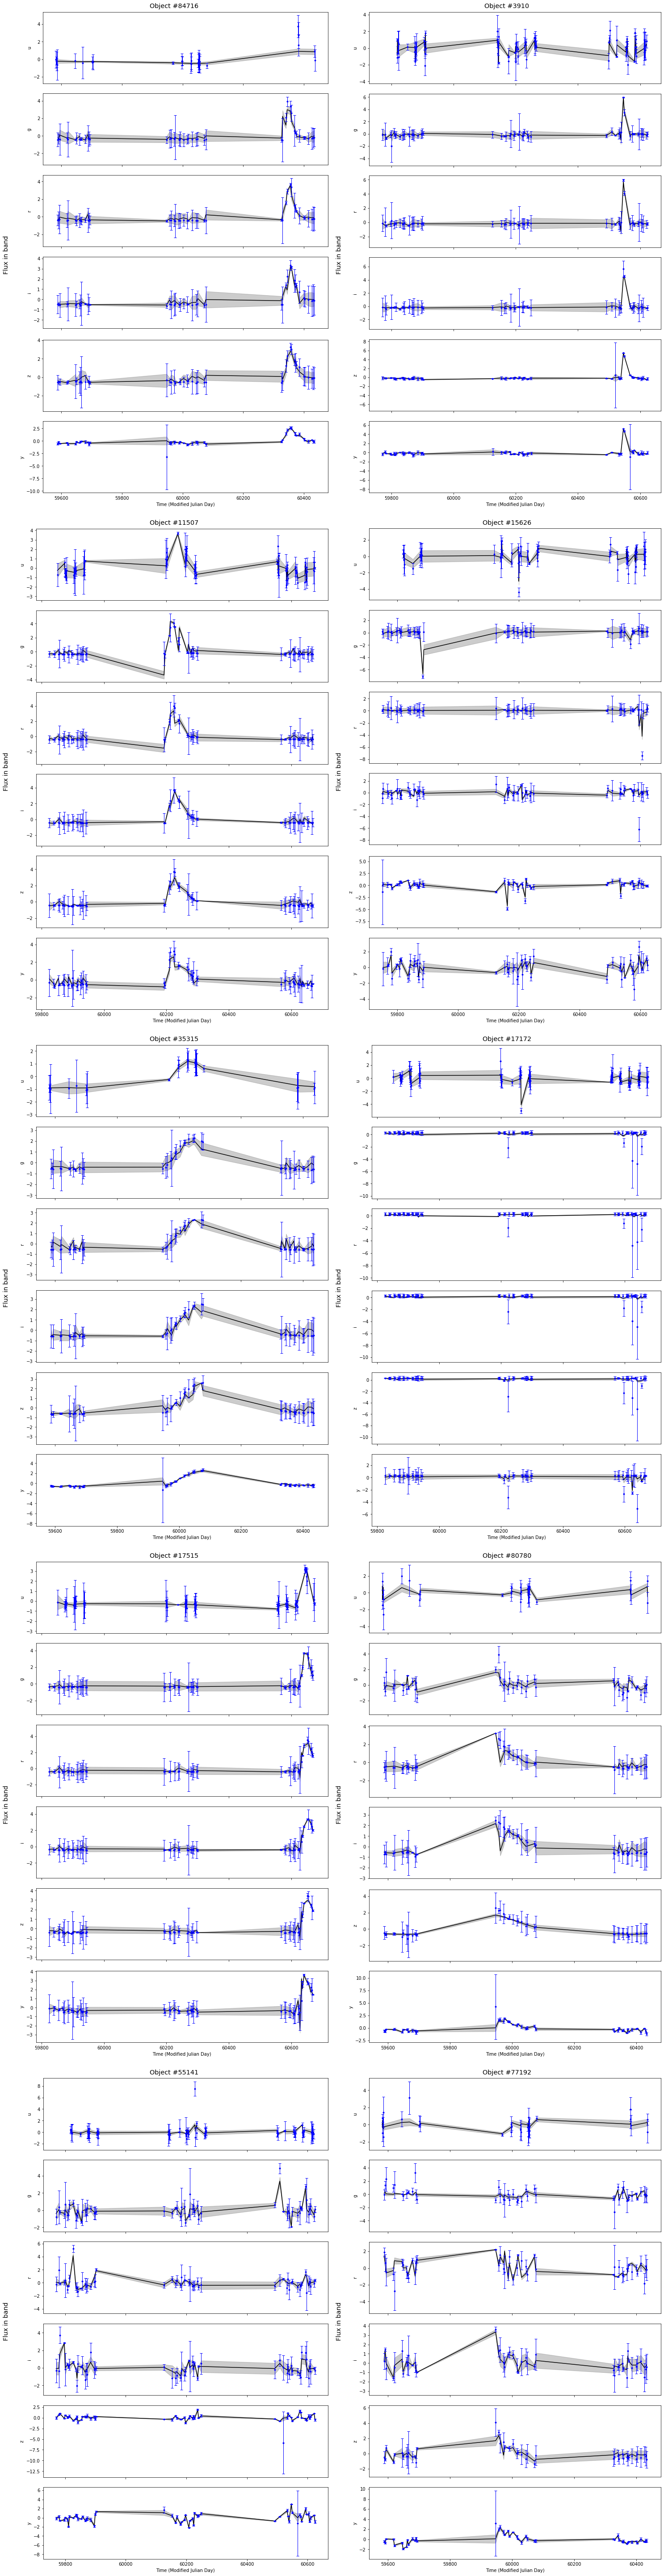

In [56]:
# Objects to be selected from the subset to visualize the data
test_index = np.array([-1, 21, 64, 89, 203, 102, 106, 478, 312, 450])
#test_index = np.array([-1, 89])
fig = pl.figure(constrained_layout=True, figsize=(20,80))
subfigs = fig.subfigures(5, 2, wspace=0.07)
row = 0

#Store the results in a numpy array
#First column is object id, second band, third and fourth the parameters
results = np.zeros((len(test_index) * 6, 5))
c = 0
for h, k in enumerate(test_index):
  test_object = lcvs[lcvs.object_id == unique_objects[k]]
  axs = subfigs[row, h%2].subplots(nrows = bandas.size, ncols = 1, sharex = True)
  for ind, ax in enumerate(axs):
    temp = test_object[test_object.passband == bandas[ind]]
    y = temp.fluxnormed.values

    #Use a gaussian kernel
    kernel = np.var(y) * kernels.Product(kernels.ExpSquaredKernel(0.5), kernels.CosineKernel(1))
    gp = george.GP(kernel)
    gp.compute(temp.mjd.values, temp.fluxnormed_err.values)
    
    #Optimize the parameters

    result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
    gp.set_parameter_vector(result.x)
    results[c, 0] = k
    results[c, 1] = bandas[ind]
    results[c, 2] = result.x[0]
    results[c, 3] = result.x[1]
    results[c, 4] = result.x[2]
    c = c + 1
    #Fills the data
    pred, pred_var = gp.predict(temp.fluxnormed.values, temp.mjd.values, return_var=True)
    
    ax.fill_between(temp.mjd.values, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var), color="k", alpha=0.2)
    ax.plot(temp.mjd.values, pred, "k", lw=1.5, alpha=1)
    ax.errorbar(temp.mjd.values , temp.fluxnormed.values, temp.fluxnormed_err.values, fmt='.', color='b', elinewidth=1, capsize=3)
    ax.set_ylabel(bands_names[ind])
  
  subfigs[row, h%2].suptitle('Object #{}'.format(unique_objects[k]), fontsize='x-large')
  subfigs[row, h%2].text(-0.05, 0.5, 'Flux in band', va='center', rotation='vertical', fontsize = 14)
  pl.xlabel('Time (Modified Julian Day)')

  if h%2 ==1 : row = row+1
pl.show()

**Fig 4** Gaussian Process interpolation for 10 objects from the dataset. The procedure was done for each band of every object individually. When considering the uncertainties the 
One aspect to look at is the effect of the outliers. Most of these datapoints did not contaminated the behavior of the interpolation, and given the size of their uncertainties they are also contained within the predictions. One exeption is object 15626 in the g-band plot, we can see how the outlier changed drastically the behavior. In particular this datapoint has a very small uncertainty, which might be the reason why this happened.

The choice of including a periodic kernel for all of the objects is not the most appropiate one, in comparison to when I ran the algorithm with only the exponential kernel, bands r, i, g from object 80780, exhibit an oscillatory behaviour when it would be expected to have only a decreasing one, since the maximum brightness occur near the observation gap, thus we only have the information of its fading part.

In [61]:
print("Variance for the parameters")
print(results[:,2].mean(), results[:,2].std())
print(results[:,3].mean(), results[:,3].std())
print(results[:,4].mean(), results[:,4].std())

Variance for the parameters
-0.5261825978157121 0.8261008078326909
4.961648252640303 4.207529455711144
1.8849374128339096 2.334984031269486


The variance of the parameters is comparable to the mean.

# CHALLENGE (Extra Credit): fit the 2D time series: 
- create a 2D array for each of the ~10 time series you used earlier: 1 dimension is time the other is wavelength (the bandpass)
- fit a 2D kernel to the time series. 
- show the fits with their uncertainties marginalized along one feature at a time: the fit along the time axis for all 6 bands and the fit along the wavelength axis for a subset of the datapoints.
- (try and make a surface plot  that conveys the relevant info effectively, I find it difficult)